## Compare Signature1000 velocity profiles to linear wave theory (LWT) predictions.o
ROXSI Asilomar 2022 experiment data.

In [1]:
# Imports
import os
import glob
import numpy as np 
import pandas as pd
import xarray as xr
from scipy.signal import detrend
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib widget
import cmocean
from PyPDF2 import PdfWriter
from roxsi_pyfuns import wave_spectra as rpws
import warnings
warnings.filterwarnings("ignore")

# Defaulkt mooring IDs and serial numbers
mids = {'103206':'L5', '103088':'C1', '103094':'C3'} # Mooring IDs from experiment
sig_mids = {'C1':'SO', 'C3':'SM', 'C6':'SI', 'L1':'SS', 'L5':'SN'} # Mooring IDs used in paper


In [2]:
# Functions
def velocity_statistics(ds, dsa, seglen='1h', fs=4, theta=25):
    """
    ADCP beam velocity statistics estimated from beam velocities.

    Parameters:
        ds - xr.Dataset with beam velocities:
             ['vB1', 'vB2', 'vB3', 'vB4', 'vB5']
        seglen - str; segment length
        fs - float; sampling frequency (Hz)
        theta - float; beam angle to vertical (degrees)

    Returns:
        ds_out - xr.Dataset with spectra and variance for each beam 
                 velocity in input ds

    """
    thetar = np.deg2rad(theta) # Beam angle in radians
    # Define segment start/end times 
    t0 = pd.Timestamp(ds.time.values[0]).floor(seglen)
    t1 = pd.Timestamp(ds.time.values[-1]).ceil(seglen)
    seg_range = pd.date_range(t0, t1, freq=seglen)
    N = int(pd.Timedelta(seglen).total_seconds()) * fs # Samples in segment 
    # Lists for concatenating spectra
    dsd = {} # Dict for concatenated spectrum datasets
    times = [] # Spectrum timestamps
    # Iterate over beams
    print('Estimating velocity spectra ...')
    for kb in tqdm(['vB1', 'vB2', 'vB3', 'vB4', 'vB5']):
        dsl_spec = [] # List for concatenating spectra
        # Iterate over segments and estimate beam velocity spectra
        for t0s, t1s in zip(seg_range[:-1], seg_range[1:]):
            times.append(t0s) # Append time
            # Iterate over range bins
            bin_spec = [] # List to store spectra by range bin
            for rbin in ds.range.values:
                # Take out segment for current beam velocity
                seg = ds[kb].sel(time=slice(t0s,t1s), range=rbin).copy()
                # Estimate beam velocity spectrum if enough valid values
                nseg = len(seg.values) # Segment length
                # Allow max 10% NaNs
                if np.sum(np.isnan(seg.values)) < 0.1*nseg:
                    # Interpolate and estimate spectrum
                    seg_i = seg.interpolate_na(dim='time').bfill(dim='time').ffill(dim='time')
                    ds_spec = rpws.spec_uvz(detrend(seg_i.values), fs=fs)
                    # Add range to spectrum dataset
                    ds_spec = ds_spec.assign_coords(range=[rbin])
                    # print(f'ds_spec.Ezz: {ds_spec.Ezz}')
                    # Save spectrum to dataset with range coord/dim and append to list
                    spec = xr.Dataset(data_vars={'Ezz':(['freq','range'], np.atleast_2d(ds_spec.Ezz.values).T)},
                                      coords=dict(freq=(['freq'], ds_spec.freq.values),
                                                  range=(['range'], [rbin]),
                                                  ),
                                      )
                    # Also compute variance of beam velocity and add to dataset
                    var = np.var(seg_i.values)
                    spec['variance'] = (['range'], [var])
                    # Append spectrum to list
                    bin_spec.append(spec)
                else:
                    # Not enough good data, save array of NaNs
                    seg_dummy = np.arange(N) * np.cos(np.arange(N)) # Dummy array
                    ds_spec = rpws.spec_uvz(seg_dummy, fs=fs) # Dummy spectrum
                    nan_array = np.ones(len(ds_spec.freq.values)) * np.nan # NaN array for dataset
                    # Make empty spectrum (all NaN) and append to list
                    empty_spec = xr.Dataset(data_vars={'Ezz':(['freq','range'], np.atleast_2d(nan_array).T)},
                                            coords=dict(freq=(['freq'], ds_spec.freq.values),
                                                        range=(['range'], [rbin]),
                                                        ),
                                            )
                    # Add NaN variance to dataset
                    empty_spec['variance'] = (['range'], [np.nan])
                    bin_spec.append(empty_spec)
            # Concatenate spectra for current beam by range
            spectral_profile = xr.concat(bin_spec, dim='range')
            # Add time coord. to spectrum dataset
            spectral_profile = spectral_profile.assign_coords(time=[t0s])
            # Add AST spectrum and variance (only once)
            if kb == 'vB1':
                ast = dsa.sel(time=slice(t0s,t1s)).copy() # AST segment
                ast_i = ast.interpolate_na(dim='time').bfill(dim='time').ffill(dim='time')
                if np.sum(np.isnan(ast_i.values)) == 0:
                    # Estimate AST spectrum
                    ds_spec_ast = rpws.spec_uvz(detrend(ast_i.values), fs=fs)
                    # Save to dataset
                    spectral_profile['AST_spec'] = (['freq', 'time'], np.atleast_2d(ds_spec_ast.Ezz.values).T)
                    spectral_profile['AST_var'] = (['time'], [np.var(ast_i.values)])
                    # Full water depth
                    spectral_profile['depth'] = (['time'], [np.mean(ast_i.values)+0.35])
                    # LWT estimates of hor. and vertical velocity
                    m0 = rpws.spec_moment(ds_spec_ast.Ezz.values, ds_spec_ast.freq.values, 0)
                    m1 = rpws.spec_moment(ds_spec_ast.Ezz.values, ds_spec_ast.freq.values, 1)
                    fm = m1 / m0 # Mean wave freq. from AST spectrum
                    fp = rpws.peak_freq(ds_spec_ast.Ezz.values, ds_spec_ast.freq.values) # peak freq
                    spectral_profile['fm'] = (['time'], [fm])
                    spectral_profile['fp'] = (['time'], [fp])
                    # Mean/peak wavenumbers
                    km = rpws.waveno_full(2*np.pi*fm, np.mean(ast_i.values)+0.35)
                    kp = rpws.waveno_full(2*np.pi*fp, np.mean(ast_i.values)+0.35)
                    spectral_profile['km'] = (['time'], [km.item()])
                    spectral_profile['kp'] = (['time'], [kp.item()])
                else:
                    # For missing values save NaNs
                    ast_dummy = np.arange(N) * np.cos(np.arange(N)) # Dummy array
                    ds_spec_ast = rpws.spec_uvz(ast_dummy, fs=fs) # Dummy spectrum
                    nan_array = np.ones(len(ds_spec_ast.freq.values)) * np.nan # NaN array for dataset
                    spectral_profile['AST_spec'] = (['freq', 'time'], np.atleast_2d(nan_array).T)
                    spectral_profile['AST_var'] = (['time'], [np.nan])
                    spectral_profile['depth'] = (['time'], [np.nan])
                    spectral_profile['fm'] = (['time'], [np.nan])
                    spectral_profile['km'] = (['time'], [np.nan])
                    spectral_profile['fp'] = (['time'], [np.nan])
                    spectral_profile['kp'] = (['time'], [np.nan])
            # Append to list
            dsl_spec.append(spectral_profile)
        # Concatenate spectral profiles by time
        dsd[kb] = xr.concat(dsl_spec, dim='time')

    # Compute horizontal velocity statistics. Start with u-vel. spec.
    ds_out = (dsd['vB1'].Ezz + dsd['vB3'].Ezz - 2*dsd['vB5'].Ezz*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out = ds_out.to_dataset().rename({'Ezz':'Uspec'}) # Rename first variable
    # Add v-velocity spectrum
    ds_out['Vspec'] = (dsd['vB2'].Ezz + dsd['vB4'].Ezz - 2*dsd['vB5'].Ezz*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out['Wspec'] = dsd['vB5'].Ezz * 1
    ds_out['ASTspec'] = dsd['vB1'].AST_spec * 1
    # Estimate total hor. vel. variance
    ds_out['Uvar'] = (dsd['vB1'].variance + dsd['vB3'].variance - 2*dsd['vB5'].variance*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out['Vvar'] = (dsd['vB2'].variance + dsd['vB4'].variance - 2*dsd['vB5'].variance*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out['Wvar'] = dsd['vB5'].variance * 1
    ds_out['ASTvar'] = dsd['vB1'].AST_var * 1
    ds_out['depth'] = dsd['vB1'].depth * 1
    ds_out['fm'] = dsd['vB1'].fm * 1
    ds_out['km'] = dsd['vB1'].km * 1
    ds_out['fp'] = dsd['vB1'].fp * 1
    ds_out['kp'] = dsd['vB1'].kp * 1
    
    return ds_out




Read data for desired ADCP (use serial number), perform QC on beam velocities based on beam amplitude and correlation, and compare estimated velocity statistics to LWT.

In [9]:
# Paths etc
ser = '103088' # Signature ADCP serial number
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
sigdir = os.path.join(rootdir, 'Signatures')
datadir = os.path.join(sigdir, 'Level1', ser)
outdir = os.path.join(datadir, 'beam_vel')
if not os.path.isdir(outdir):
    os.mkdir(outdir)
# Date(s) to analyse
t0 = pd.Timestamp('2022-07-05')
# ndays = 1 # Number of days
# t1 = t0 + pd.Timedelta(days=ndays)
t1 = pd.Timestamp('2022-07-14')
# Define output velocity spectrum and variance dataset nc filename
fn_nc_out = os.path.join(sigdir, f'{ser}_vel_stats_{t0.strftime("%Y%m%d")}_{t1.strftime("%Y%m%d")}.nc')
if not os.path.isfile(fn_nc_out):
    dates = pd.date_range(t0, t1, freq='1d')
    # Perform QC on beam velocities and concatenate to one dataset
    dsl_v = [] # Empty list for concatenating QC'd beam vel. datasets
    dsl_a = [] # Empty list for concatenating despiked AST range datasets
    amp_thresh = 40 # Beam amplitude minimum threshold (dB)
    corr_thresh = 75 # Beam correlation minimum threshold (%)
    print('Beam velocity QC ...')
    for date in tqdm(dates):
        datestr = date.strftime('%Y%m%d')
        # Read beam velocity dataset for current date
        fn_nc = os.path.join(datadir, f'Asilomar_SSA_Sig_Vel_{ser}_{datestr}_v2.nc')
        dsi = xr.open_dataset(fn_nc)
        # Make masks for keeping only good values
        # valid = (dsi.range < (0.9 * dsi.ASTd.min(dim='time').item())) # Valid range values below surface
        # valid = (dsi.range < (0.9 * dsi.ASTd.resample(time='1h').mean())) # Valid range values below surface
        valid = (dsi.range < (0.9 * dsi.ASTd)) # Valid range values below surface
        good = {'B1': ((dsi.ampB1>amp_thresh) & (dsi.corrB1>corr_thresh)), # Good Beam1 values based on amp&corr
                'B2': ((dsi.ampB2>amp_thresh) & (dsi.corrB2>corr_thresh)), # Good Beam2 values based on amp&corr
                'B3': ((dsi.ampB3>amp_thresh) & (dsi.corrB3>corr_thresh)), # Good Beam3 values based on amp&corr
                'B4': ((dsi.ampB4>amp_thresh) & (dsi.corrB4>corr_thresh)), # Good Beam4 values based on amp&corr
                'B5': ((dsi.ampB5>amp_thresh) & (dsi.corrB5>corr_thresh)), # Good Beam5 values based on amp&corr
                }
        keys = ['vB1', 'vB2', 'vB3', 'vB4', 'vB5'] # Keys for beam vel.
        # Only keep valid/good beam velocities
        good_vb = dsi[keys].where((valid & good['B1'] & good['B2'] & good['B3'] & good['B4'] & good['B5'])).copy()
        # Append to lists for concatenating
        dsl_v.append(good_vb)
        dsl_a.append(dsi.ASTd)
    # Concatenate QC'd beam vel. datasets
    dsv = xr.concat(dsl_v, dim='time')
    dsa = xr.concat(dsl_a, dim='time')

    # Estimate velocity statistics for beam velocities and save to netcdf
    dss = velocity_statistics(dsv, dsa)
    # Save to netcdf
    dss.to_netcdf(fn_nc_out)
else:
    # Read premade file
    dss = xr.open_dataset(fn_nc_out, decode_coords='all')


Beam velocity QC ...


  0%|          | 0/10 [00:00<?, ?it/s]

Estimating velocity spectra ...


  0%|          | 0/5 [00:00<?, ?it/s]

Plot individual hourly velocity profiles for given serial numbers.

In [ ]:
plt.clf()
plt.close()

sers = ['103088', '103094', '103206']
# mids = {'103206':'L5', '103088':'C1', '103094':'C3', '103110':'C6'} # Mooring IDs
mids = {'103206':'L5', '103088':'C1', '103094':'C3'} # Mooring IDs
sig_mids = {'C1':'SO', 'C3':'SM', 'C6':'SI', 'L1':'SS', 'L5':'SN'}
dsd = []
for ser in sers:
    fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714.nc')
    dsd.append(xr.open_dataset(fn_nc, decode_coords='all'))

# Time to plot
t0p = pd.Timestamp('2022-07-13 05:00')
cs = ['C0', 'C1', 'C2'] # Plot line colors
fig, axes = plt.subplots(figsize=(8,8), ncols=2, sharey=True, sharex=True)
for ds,ser,c in zip(dsd,sers,cs):
    mid = mids[ser]
    loc = sig_mids[mid]
    # Depth offset vs. SN depth
    depth_loc = ds.depth.sel(time=t0p).item()
    depth_north = dsd[-1].depth.sel(time=t0p).item()
    d_offset = depth_north - depth_loc
    dp = ((ds.range.values + d_offset) - depth_north)# / depth_north
    # (ds.Uvar + ds.Vvar).sel(time=t0p).plot(ax=axes[0], y='range', label=ser)
    axes[0].plot(np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p), dp, label=loc, c=c)
    # ds.Wvar.sel(time=t0p).plot(ax=axes[1], y='range', label=ser)
    axes[1].plot(np.sqrt(ds.Wvar).sel(time=t0p), dp, label=loc, c=c)
    # LWT estimate
    m0 = rpws.spec_moment(ds.ASTspec.sel(time=t0p).values, ds.freq.values, 0)
    m1 = rpws.spec_moment(ds.ASTspec.sel(time=t0p).values, ds.freq.values, 1)
    fm = m1 / m0 # Mean wave freq. from AST spectrum
    k = rpws.waveno_full(2*np.pi*fm, depth_loc)
    u_lwt = np.cosh(k*(ds.range+0.35)) / np.sinh(k*depth_loc) * np.sqrt(np.mean(ds.ASTvar.sel(time=t0p)))*2*np.pi*fm
    axes[0].plot(u_lwt, dp, label=f'{loc} (LWT)', c=c, ls='--')
    w_lwt = np.sinh(k*(ds.range+0.35)) / np.sinh(k*depth_loc) * np.sqrt(np.mean(ds.ASTvar.sel(time=t0p)))*2*np.pi*fm
    axes[1].plot(w_lwt, dp, label=f'{loc} (LWT)', c=c, ls='--')
axes[0].set_xlabel(r'$\sqrt{(\mathrm{Uvar + Vvar)}}$ [m/s]')
axes[1].set_xlabel(r'$\sqrt{\mathrm{Wvar}}$ [m/s]')
axes[0].set_ylabel('Depth below surface [m]')
axes[1].set_ylabel(None)
for ax in axes:
    ax.legend()
    ax.set_title(None)
    ax.set_xlim([0,0.5])
    ax.set_ylim([None,0])

plt.suptitle(str(t0p))
plt.tight_layout()
plt.show()

Plot profiles of measured/LWT estimates of std(U) and std(W) for given serial number.

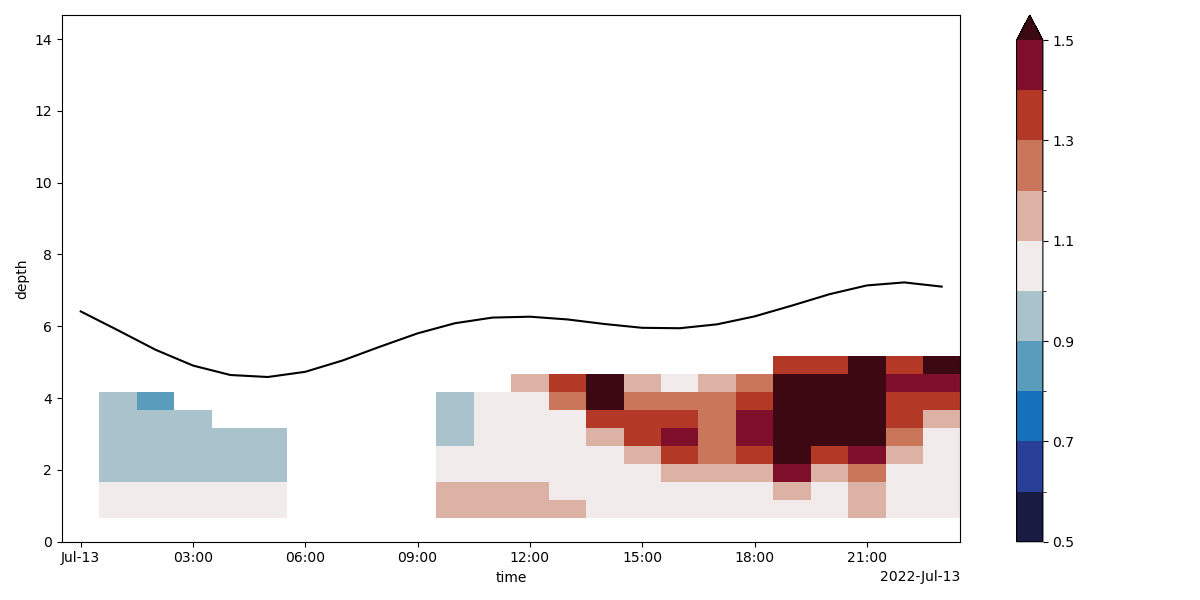

In [13]:
plt.clf()
plt.close()

# Date to plot
t0p = '2022-07-13'
# Define serial number to plot and read netcdf file
ser = '103094'
mid = mids[ser]
loc = sig_mids[mid]
fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714.nc')
ds = xr.open_dataset(fn_nc, decode_coords='all')

# Plot measured U_std vs LWT estimate
fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p), ds.range)
# Measured std(U)
u_meas = np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p).copy()
# u_meas = (ds.Uvar + ds.Vvar).sel(time=t0p).copy()
# LWT estimate
k = ds.km.sel(time=t0p).copy()
f = ds.fm.sel(time=t0p).copy()
z = ds.range.copy()
h = ds.depth.sel(time=t0p).copy()
ASTvar = ds.ASTvar.sel(time=t0p).copy()
u_lwt = np.cosh(k*z) / np.sinh(k*h) * np.sqrt(np.mean(ASTvar))*2*np.pi*f
# Plot profiles of ratio of u_meas/u_lwt
u_ratio = (u_meas/u_lwt)
# Set min/max range for colormap
vmax = abs(max(u_ratio.max().item(), u_ratio.min().item()))
dv = vmax - 1
# Plot
# u_ratio.plot.pcolormesh(ax=ax, x='time', y='range', cmap=cmocean.cm.balance, vmin=1-dv, vmax=1+dv)
u_ratio.plot.pcolormesh(ax=ax, x='time', y='range', cmap=cmocean.cm.balance, vmin=0.5, vmax=1.5, levels=11)
ds.depth.sel(time=t0p).plot(ax=ax, c='k')

# Axis limits, labels, etc
ax.set_ylim([0,None])

plt.tight_layout()
plt.show()



In [12]:
np.linspace(0.5,1.5,11)

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])

Same as previous plot, but for vertical velocity profiles.

In [ ]:
plt.clf()
plt.close()

# Date to plot
t0p = '2022-07-13'
# Define serial number to plot and read netcdf file
ser = '103088'
mid = mids[ser]
loc = sig_mids[mid]
fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714.nc')
ds = xr.open_dataset(fn_nc, decode_coords='all')

# Plot measured U_std vs LWT estimate
fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p), ds.range)
# Measured std(U)
w_meas = np.sqrt(ds.Wvar).sel(time=t0p).copy()
# LWT estimate
k = ds.km.sel(time=t0p).copy()
f = ds.fm.sel(time=t0p).copy()
z = ds.range.copy()
h = ds.depth.sel(time=t0p).copy()
ASTvar = ds.ASTvar.sel(time=t0p).copy()
w_lwt = np.sinh(k*z) / np.sinh(k*h) * np.sqrt(np.mean(ASTvar))*2*np.pi*f
# Plot profiles of ratio of w_meas/w_lwt
w_ratio = (w_meas/w_lwt)
# Set min/max range for colormap
vmax = abs(max(w_ratio.max().item(), w_ratio.min().item()))
dv = vmax - 1
print(f'dv: {dv}')
# Plot
w_ratio.plot.pcolormesh(ax=ax, x='time', y='range', cmap=cmocean.cm.balance, vmin=1-dv, vmax=1+dv)

# Axis limits, labels, etc
ax.set_ylim([0,6])

plt.tight_layout()
plt.show()

In [ ]:
u_meas
ds.sel(time='2022-07-13')

In [ ]:
dss

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dsd['vB1'].isel(time=1).Ezz.plot(ax=ax, x='freq', y='range')
plt.show()